In [1]:
%run -i ./preamble.py

In [2]:
from simulate import *
from inverse_moments import *

In [3]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
plt.rcParams["figure.figsize"] = (3.0, 3.0)
plt.rcParams["figure.dpi"] = 500
plt.rcParams["font.size"] = 12

In [5]:
lambda0 = 1
beta = 1.5
lambdaS = 1
lambdaE = 2
rho = 2
mat = 2.5

In [6]:
selfCol = "tab:green"
extCol = "tab:purple"

In [7]:
dt = 1e-10

In [8]:
from matplotlib.patches import FancyArrowPatch

In [9]:
plt.rcParams["legend.columnspacing"]

2.0

In [10]:
plt.rcParams["legend.columnspacing"] = 1.25

In [11]:
def create_steps(ts, maxT, c=None, zorder=0, **kwargs):
    dt = 1e-10

    # Add a point just before each change (t_i-dt)
    # and just after each change (t_i+dt)
    Nt = np.arange(1.0, len(ts) + 1)
    NtDup = np.sort(np.concatenate([Nt - 1, Nt - 1, Nt, Nt]))
    tsDup = np.sort(np.concatenate([ts - dt, ts, ts, ts + dt]))

    # Extend so time starts at 0 and goes till maxT
    tsDup = np.append(np.insert(tsDup, 0, 0), maxT)
    NtDup = np.append(np.insert(NtDup, 0, 0), NtDup[-1])

    # Plot the step function
#     axs[1].plot(tsDup, NtDup, c=c, zorder=zorder, **kwargs)

    # Put NaN in different places so we split up horizonal
    # parts of the step function from the vertical
    NtHoriz = NtDup.copy()
#     NtVert = NtDup.copy()
    NtHoriz[2::4] = np.NaN
#     NtVert[1::4] = np.NaN
    # Plot the horizontal and vertical parts of the step function
    axs[1].plot(tsDup, NtHoriz, c=c, zorder=zorder, **kwargs)
#     axs[1].plot(tsDup, NtVert, c=c, ls="--", zorder=zorder, **kwargs)

    # Add circles on the pre- post-change points
    axs[1].scatter(ts, Nt, c=c)
    axs[1].scatter(
        ts, Nt - 1, edgecolors=c, facecolors="white", zorder=zorder + 1,
    )

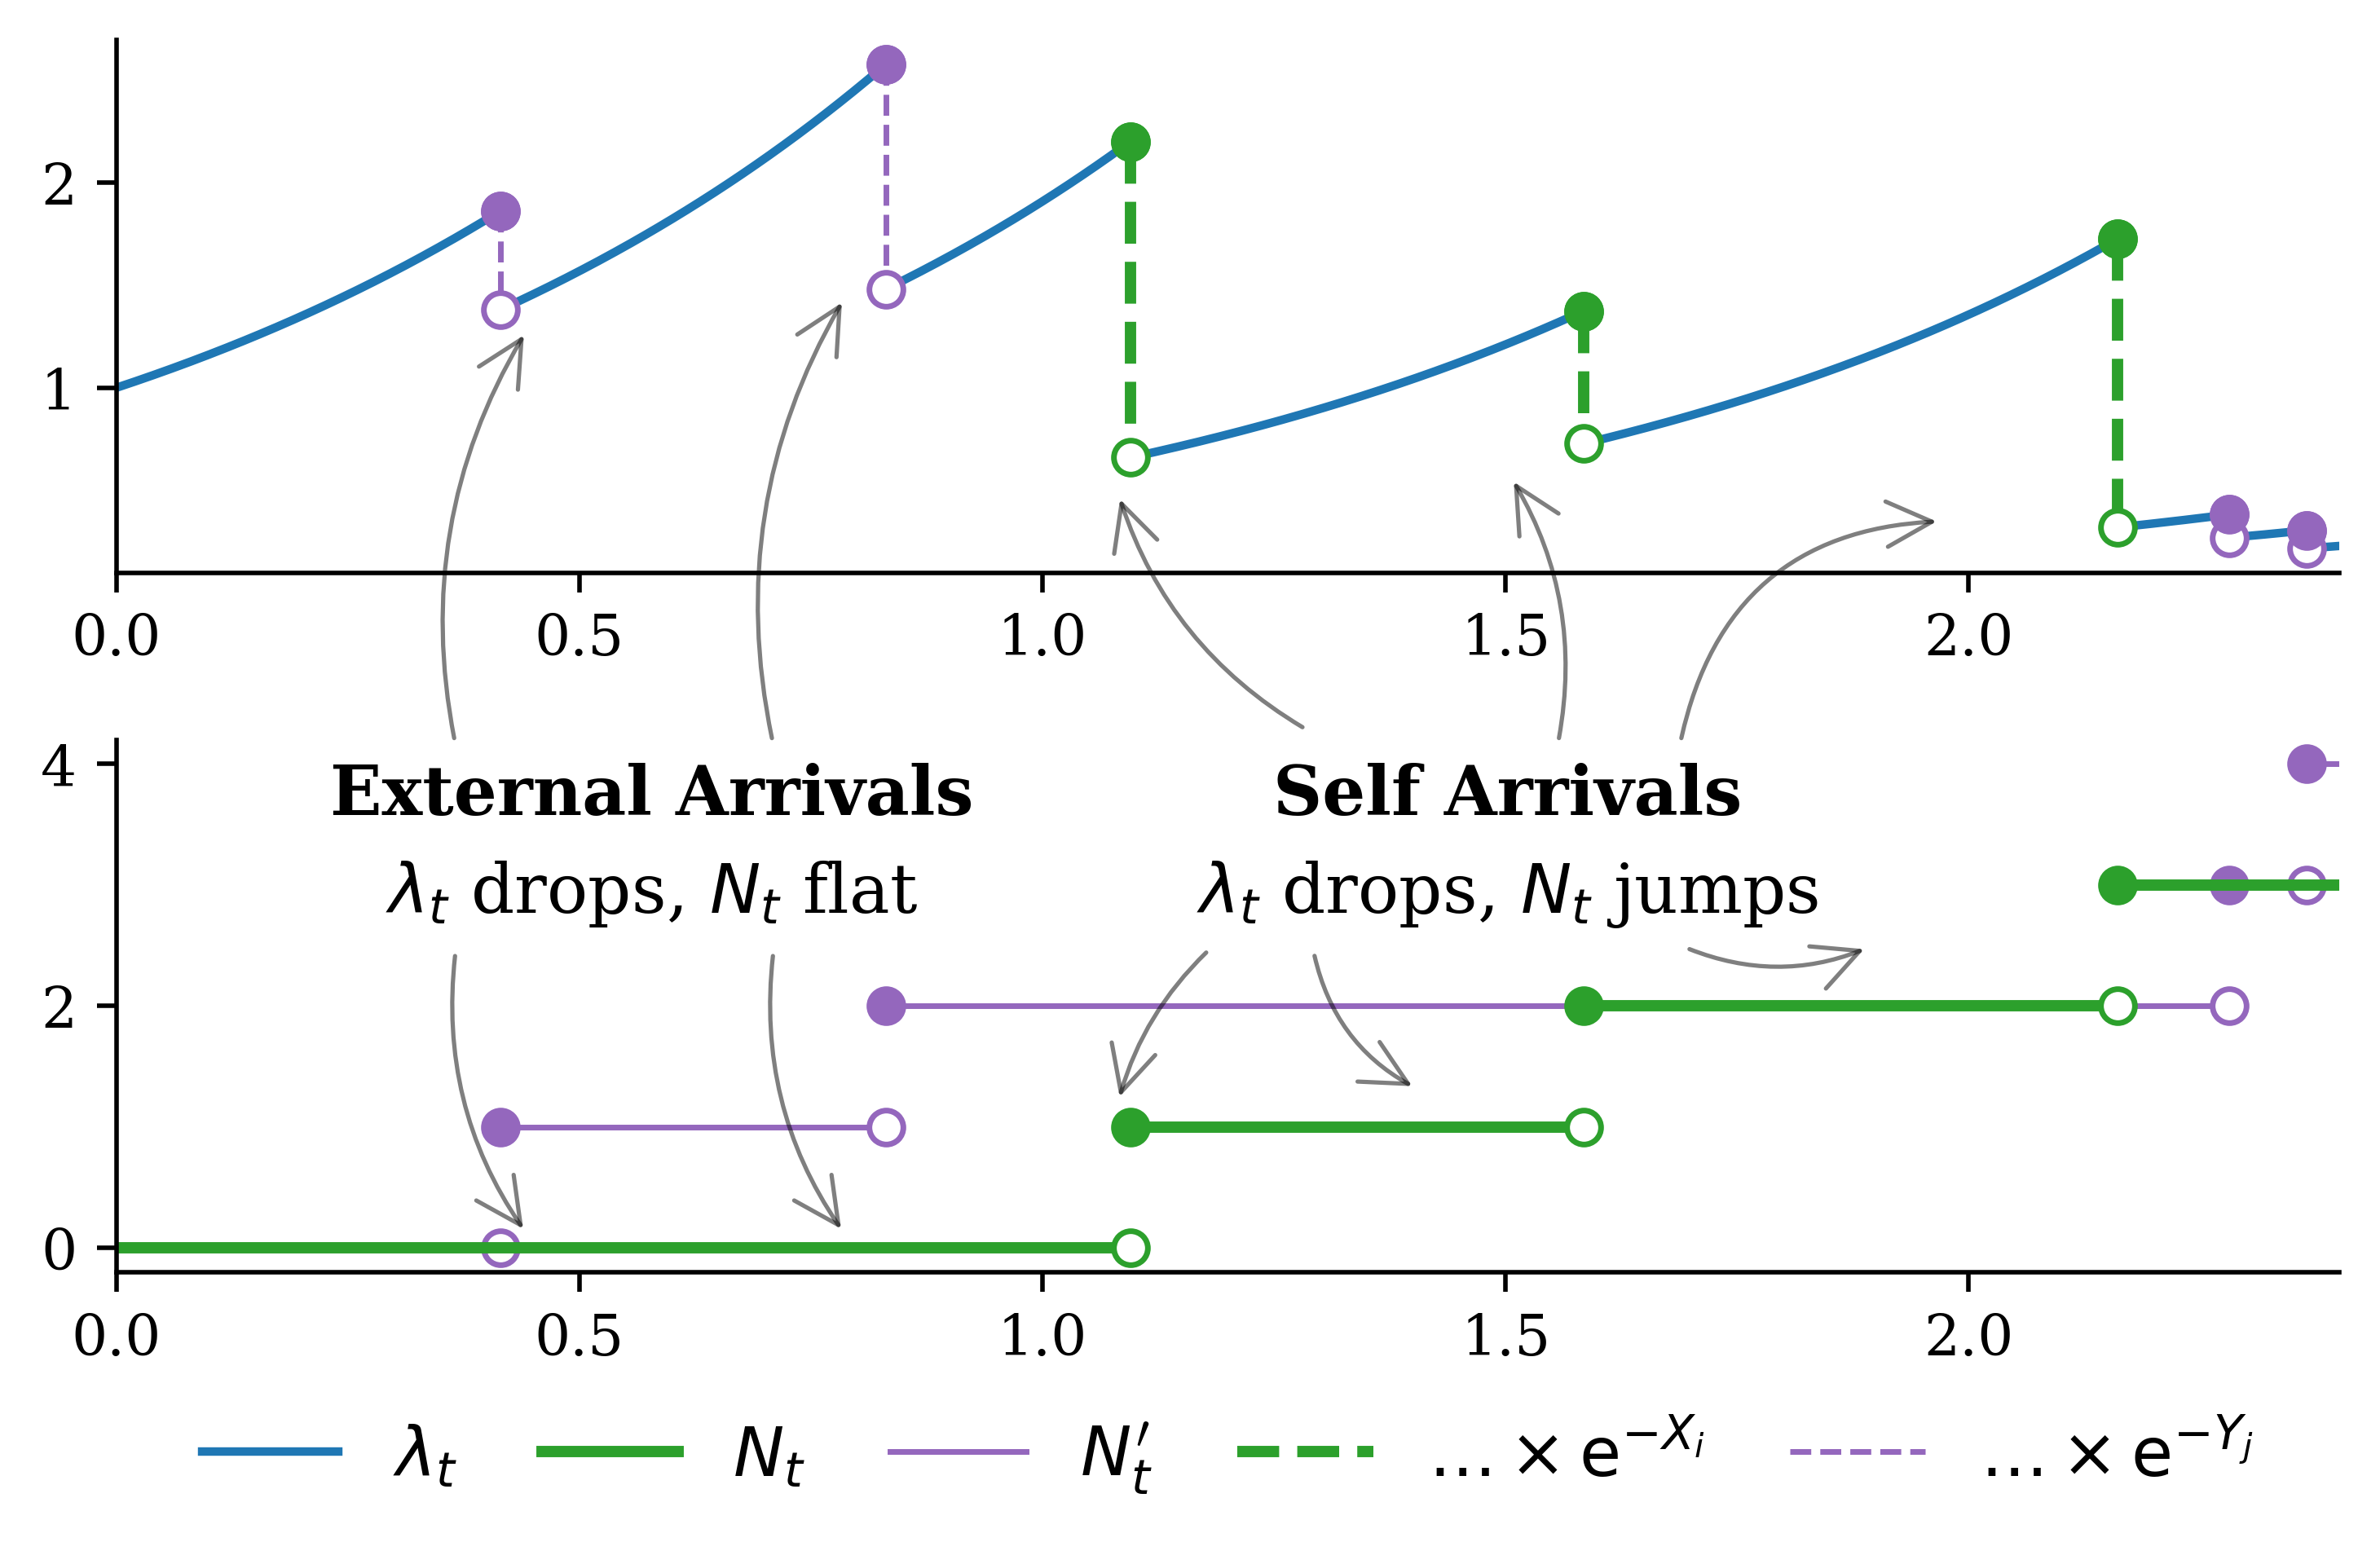

In [12]:
rnd.seed(2)
fig, axs = plt.subplots(2, 1, figsize=(6, 4), tight_layout=True)

ts, logLambdas, selfTs, extTs, Xs, Ys = simulate_exact_serially(
    lambda0, beta, lambdaS, lambdaE, rho, mat
)

tGrid = np.linspace(0, mat, 1000)

logInt = interp1d(ts, logLambdas, assume_sorted=True)
lambdas = np.exp(logInt(tGrid))
lambdas[:-1][np.diff(lambdas) < 0] = np.NaN

axs[0].plot(tGrid, lambdas, label="$\\lambda_t$")

axs[0].plot(selfTs, np.exp(logInt(selfTs - dt)), "o", c=selfCol)
axs[0].plot(extTs, np.exp(logInt(extTs - dt)), "o", c=extCol)

axs[0].scatter(selfTs, np.exp(logInt(selfTs - dt)), c=selfCol, zorder=4)
axs[0].scatter(extTs, np.exp(logInt(extTs - dt)), c=extCol, zorder=4)

axs[0].scatter(
    selfTs,
    np.exp(logInt(selfTs + dt)),
    edgecolors=selfCol,
    facecolors="white",
    zorder=3,
)
axs[0].scatter(
    extTs, np.exp(logInt(extTs + dt)), edgecolors=extCol, facecolors="white", zorder=3
)


vertTimesSelf = np.sort(np.concatenate([selfTs, selfTs - dt, selfTs + dt]))
vertLambdasSelf = np.exp(logInt(vertTimesSelf))
vertLambdasSelf[2::3] = np.NaN
axs[0].plot(
    vertTimesSelf,
    vertLambdasSelf,
    lw=2,
    ls="--",
    c=selfCol,
    label="$\\dots \\times \\mathrm{e}^{-X_i}$",
)

vertTimesExt = np.sort(np.concatenate([extTs, extTs - dt, extTs + dt]))
vertLambdasExt = np.exp(logInt(vertTimesExt))
vertLambdasExt[2::3] = np.NaN
axs[0].plot(
    vertTimesExt,
    vertLambdasExt,
    lw=1,
    ls="--",
    c=extCol,
    label="$\\dots \\times \\mathrm{e}^{-Y_j}$",
)

# plt.legend(frameon=False)
xl = [0, 2.4]
axs[0].set_xlim(xl)
axs[1].set_xlim(xl)
sns.despine()


create_steps(selfTs, xl[1], c=selfCol, zorder=2, label="$N_t$", lw=2)
create_steps(extTs, xl[1], c=extCol, label="$N_t'$", lw=1)

lines = sum([ax.get_legend_handles_labels()[0] for ax in axs], [])
labels = sum([ax.get_legend_handles_labels()[1] for ax in axs], [])

order = [0, 3, 4, 1, 2]
plt.legend(
    [lines[i] for i in order],
    [labels[i] for i in order],
    ncol=len(lines),
    frameon=False,
    bbox_to_anchor=(0.5, -0.35),
    loc="center",
    borderaxespad=0.0,
    labelspacing=0.2,
)

plt.savefig("example.pgf")

targs = {"transform": fig.transFigure, "ha": "center"} #, "fontsize": 12}
faargs = {
    #     "color": "grey",
    "arrowstyle": "->",
    "transform": fig.transFigure,
    "mutation_scale": 20.0,
    "alpha": 0.5,
    "lw": 0.75,
    #     "ls": "--",
}

fig.text(0.28, 0.48, "External Arrivals", fontweight="bold", **targs)
fig.text(0.28, 0.42, "$\\lambda_t$ drops, $N_t$ flat", **targs)

fig.text(0.63, 0.48, "Self Arrivals", fontweight="bold", **targs)
fig.text(0.63, 0.42, "$\\lambda_t$ drops, $N_t$ jumps", **targs)

# Up arrows from left side
fig.patches.append(
    FancyArrowPatch(
        (0.2, 0.52), (0.23, 0.78), connectionstyle="arc3,rad=-0.2", **faargs
    )
)
fig.patches.append(
    FancyArrowPatch(
        (0.33, 0.52), (0.36, 0.8), connectionstyle="arc3,rad=-0.2", **faargs
    )
)

# Down arrows from left side
fig.patches.append(
    FancyArrowPatch((0.2, 0.4), (0.23, 0.22), connectionstyle="arc3,rad=0.2", **faargs)
)
fig.patches.append(
    FancyArrowPatch((0.33, 0.4), (0.36, 0.22), connectionstyle="arc3,rad=0.2", **faargs)
)

# Up arrows from right side
fig.patches.append(
    FancyArrowPatch(
        (0.55, 0.53), (0.47, 0.68), connectionstyle="arc3,rad=-0.2", **faargs
    )
)
fig.patches.append(
    FancyArrowPatch(
        (0.65, 0.52), (0.63, 0.69), connectionstyle="arc3,rad=0.2", **faargs
    )
)
fig.patches.append(
    FancyArrowPatch(
        (0.7, 0.52), (0.81, 0.66), connectionstyle="arc3,rad=-0.4", **faargs
    )
)

# Down arrows from right side
fig.patches.append(
    FancyArrowPatch((0.51, 0.4), (0.47, 0.3), connectionstyle="arc3,rad=0.15", **faargs)
)
fig.patches.append(
    FancyArrowPatch(
        (0.55, 0.4), (0.595, 0.31), connectionstyle="arc3,rad=0.25", **faargs
    )
)
fig.patches.append(
    FancyArrowPatch((0.7, 0.4), (0.78, 0.4), connectionstyle="arc3,rad=0.22", **faargs)
)

axs[0].tick_params(axis='both', which='major', labelsize=10)
axs[1].tick_params(axis='both', which='major', labelsize=10)

plt.savefig("example-annotated.pgf")
plt.show()

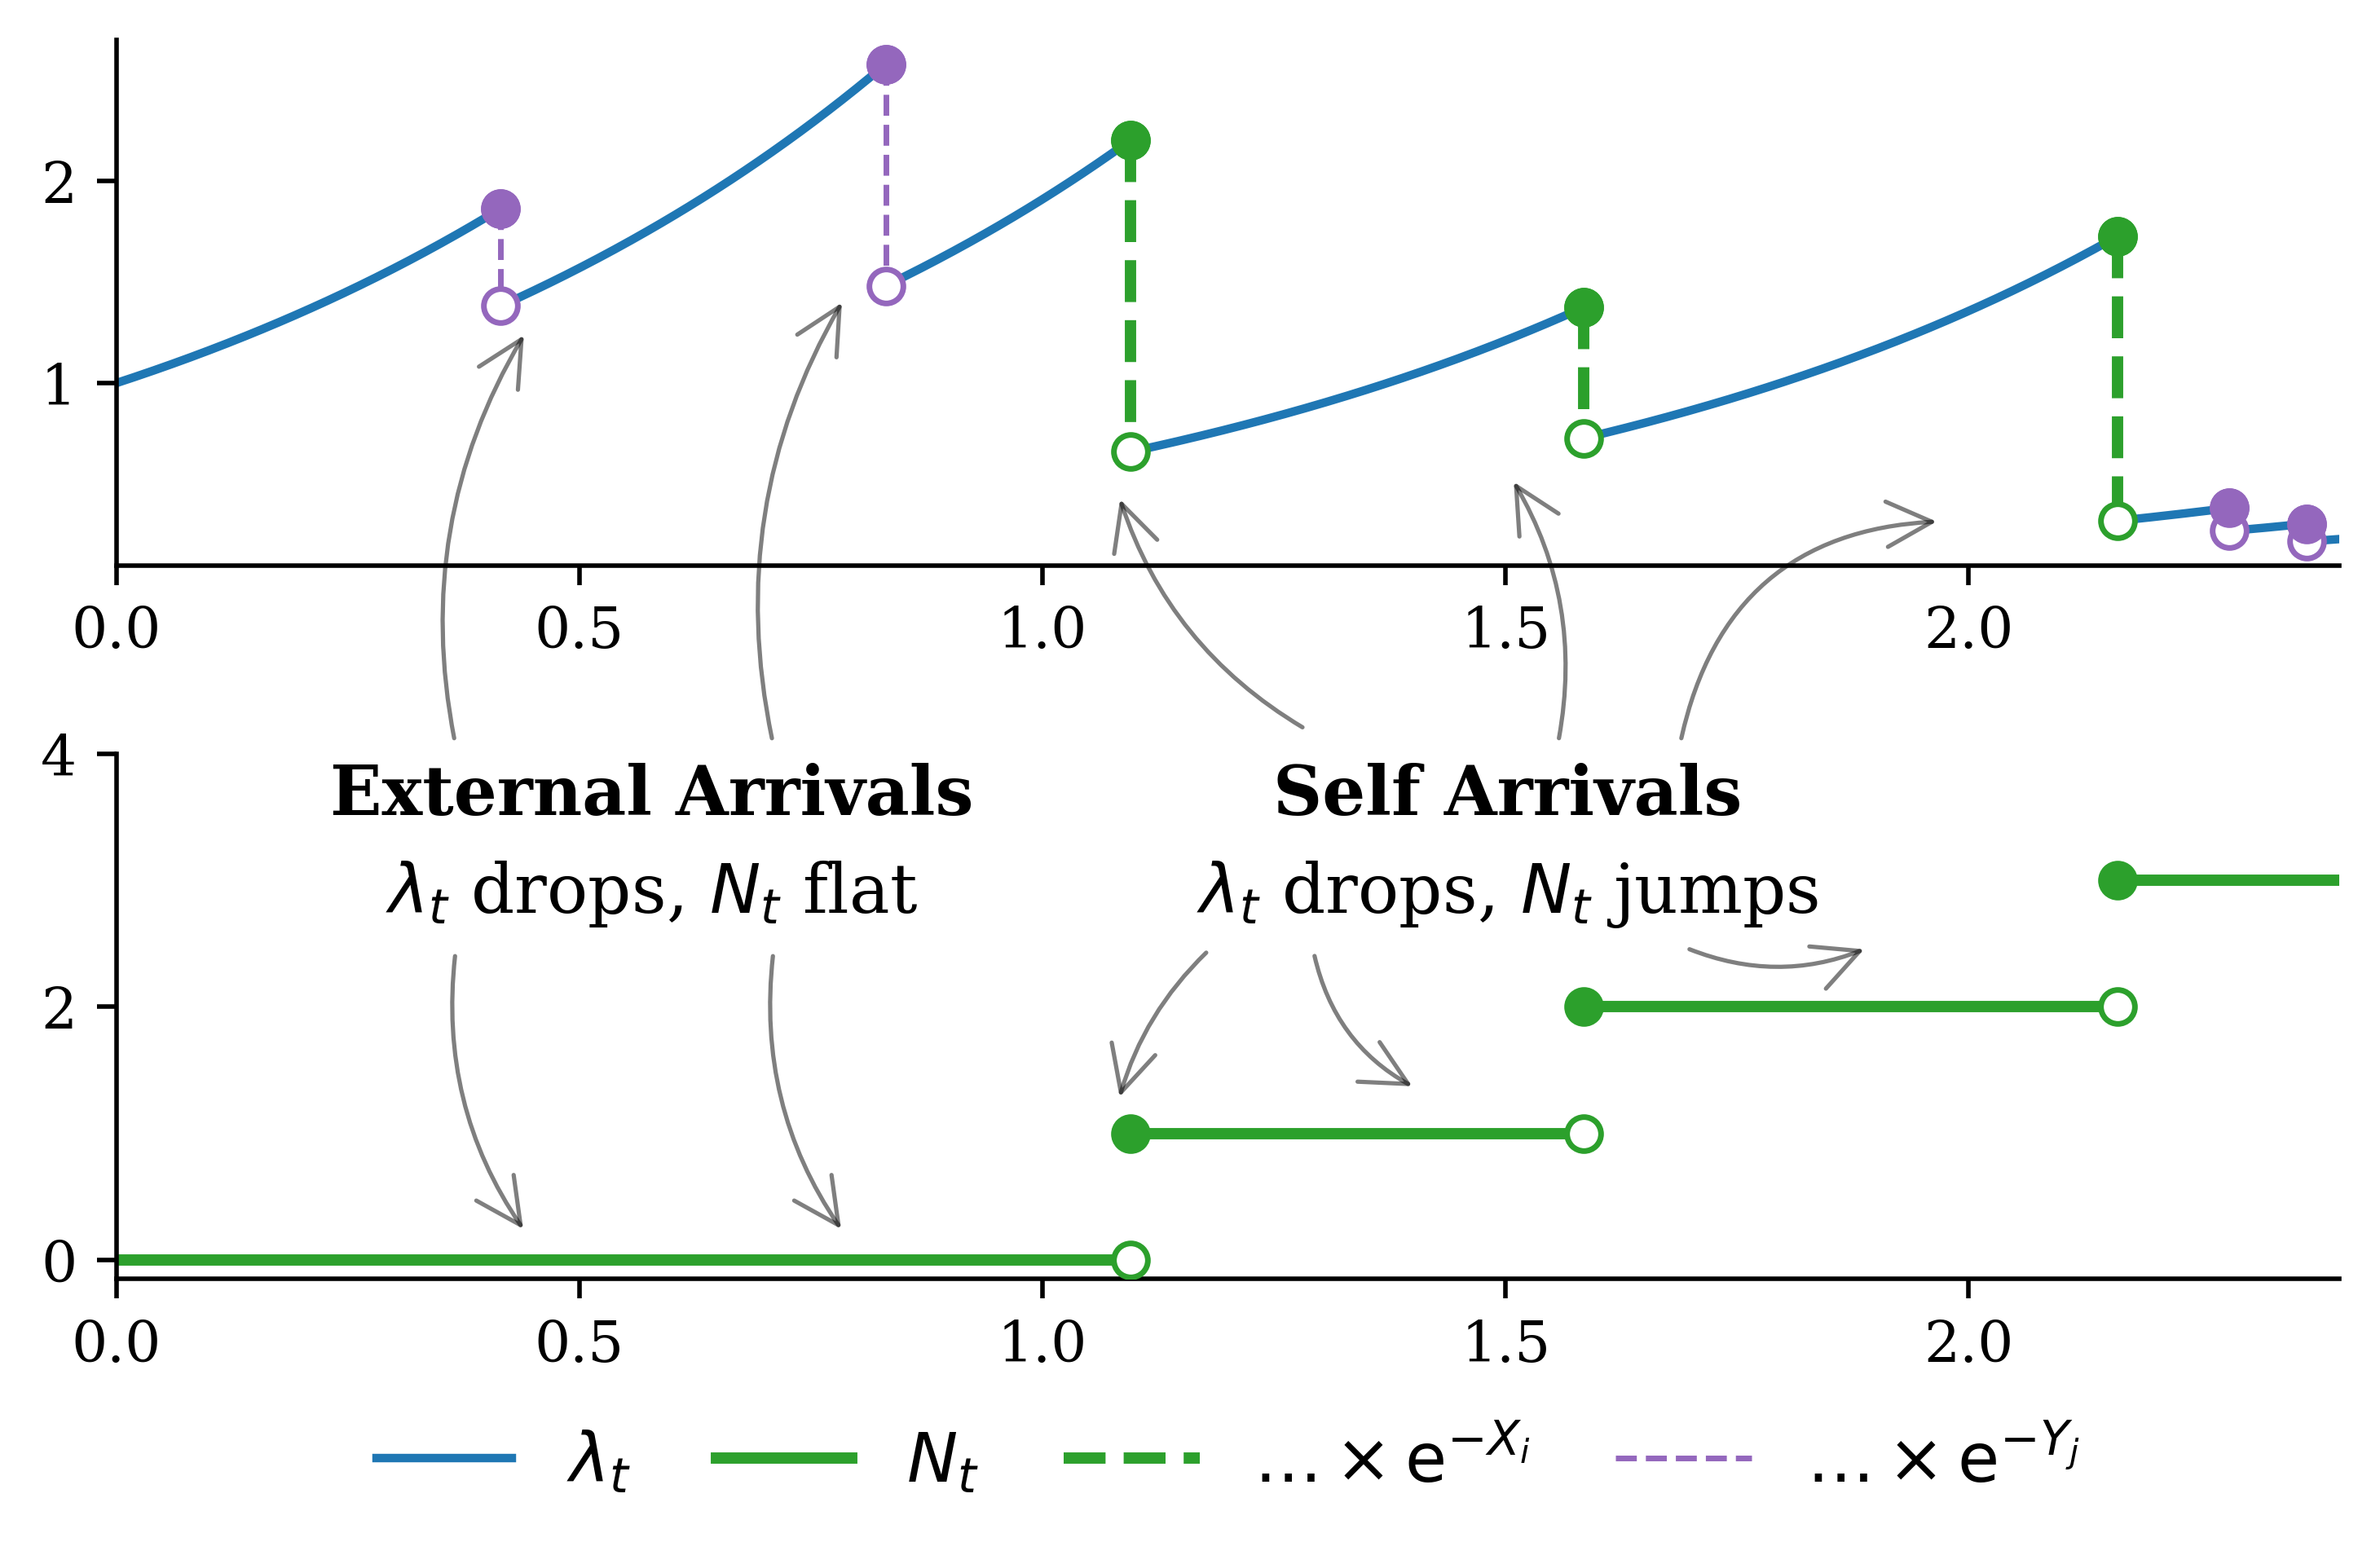

In [13]:
rnd.seed(2)
fig, axs = plt.subplots(2, 1, figsize=(6, 4), tight_layout=True)

ts, logLambdas, selfTs, extTs, Xs, Ys = simulate_exact_serially(
    lambda0, beta, lambdaS, lambdaE, rho, mat
)

tGrid = np.linspace(0, mat, 1000)

logInt = interp1d(ts, logLambdas, assume_sorted=True)
lambdas = np.exp(logInt(tGrid))
lambdas[:-1][np.diff(lambdas) < 0] = np.NaN

axs[0].plot(tGrid, lambdas, label="$\\lambda_t$")

axs[0].plot(selfTs, np.exp(logInt(selfTs - dt)), "o", c=selfCol)
axs[0].plot(extTs, np.exp(logInt(extTs - dt)), "o", c=extCol)

axs[0].scatter(selfTs, np.exp(logInt(selfTs - dt)), c=selfCol, zorder=4)
axs[0].scatter(extTs, np.exp(logInt(extTs - dt)), c=extCol, zorder=4)

axs[0].scatter(
    selfTs,
    np.exp(logInt(selfTs + dt)),
    edgecolors=selfCol,
    facecolors="white",
    zorder=3,
)
axs[0].scatter(
    extTs, np.exp(logInt(extTs + dt)), edgecolors=extCol, facecolors="white", zorder=3
)


vertTimesSelf = np.sort(np.concatenate([selfTs, selfTs - dt, selfTs + dt]))
vertLambdasSelf = np.exp(logInt(vertTimesSelf))
vertLambdasSelf[2::3] = np.NaN
axs[0].plot(
    vertTimesSelf,
    vertLambdasSelf,
    lw=2,
    ls="--",
    c=selfCol,
    label="$\\dots \\times \\mathrm{e}^{-X_i}$",
)

vertTimesExt = np.sort(np.concatenate([extTs, extTs - dt, extTs + dt]))
vertLambdasExt = np.exp(logInt(vertTimesExt))
vertLambdasExt[2::3] = np.NaN
axs[0].plot(
    vertTimesExt,
    vertLambdasExt,
    lw=1,
    ls="--",
    c=extCol,
    label="$\\dots \\times \\mathrm{e}^{-Y_j}$",
)

# plt.legend(frameon=False)
# xl = axs[0].get_xlim()
# axs[1].set_xlim(xl)

xl = [0, 2.4]
axs[0].set_xlim(xl)
axs[1].set_xlim(xl)

sns.despine()

create_steps(selfTs, xl[1], c=selfCol, zorder=2, label="$N_t$", lw=2)

yl = axs[1].get_ylim()
axs[1].set_ylim([yl[0], 4])

lines = sum([ax.get_legend_handles_labels()[0] for ax in axs], [])
labels = sum([ax.get_legend_handles_labels()[1] for ax in axs], [])

order = [0, 3, 1, 2]
plt.legend(
    [lines[i] for i in order],
    [labels[i] for i in order],
    ncol=len(lines),
    frameon=False,
    bbox_to_anchor=(0.5, -0.35),
    loc="center",
    borderaxespad=0.0,
    labelspacing=0.2,
)

plt.savefig("example-no-external.pgf")

targs = {"transform": fig.transFigure, "ha": "center"} #, "fontsize": 12}
faargs = {
    #     "color": "grey",
    "arrowstyle": "->",
    "transform": fig.transFigure,
    "mutation_scale": 20.0,
    "alpha": 0.5,
    "lw": 0.75,
    #     "ls": "--",
}

fig.text(0.28, 0.48, "External Arrivals", fontweight="bold", **targs)
fig.text(0.28, 0.42, "$\\lambda_t$ drops, $N_t$ flat", **targs)

fig.text(0.63, 0.48, "Self Arrivals", fontweight="bold", **targs)
fig.text(0.63, 0.42, "$\\lambda_t$ drops, $N_t$ jumps", **targs)

# Up arrows from left side
fig.patches.append(
    FancyArrowPatch(
        (0.2, 0.52), (0.23, 0.78), connectionstyle="arc3,rad=-0.2", **faargs
    )
)
fig.patches.append(
    FancyArrowPatch(
        (0.33, 0.52), (0.36, 0.8), connectionstyle="arc3,rad=-0.2", **faargs
    )
)

# Down arrows from left side
fig.patches.append(
    FancyArrowPatch((0.2, 0.4), (0.23, 0.22), connectionstyle="arc3,rad=0.2", **faargs)
)
fig.patches.append(
    FancyArrowPatch((0.33, 0.4), (0.36, 0.22), connectionstyle="arc3,rad=0.2", **faargs)
)

# Up arrows from right side
fig.patches.append(
    FancyArrowPatch(
        (0.55, 0.53), (0.47, 0.68), connectionstyle="arc3,rad=-0.2", **faargs
    )
)
fig.patches.append(
    FancyArrowPatch(
        (0.65, 0.52), (0.63, 0.69), connectionstyle="arc3,rad=0.2", **faargs
    )
)
fig.patches.append(
    FancyArrowPatch(
        (0.7, 0.52), (0.81, 0.66), connectionstyle="arc3,rad=-0.4", **faargs
    )
)

# Down arrows from right side
fig.patches.append(
    FancyArrowPatch((0.51, 0.4), (0.47, 0.3), connectionstyle="arc3,rad=0.15", **faargs)
)
fig.patches.append(
    FancyArrowPatch(
        (0.55, 0.4), (0.595, 0.31), connectionstyle="arc3,rad=0.25", **faargs
    )
)
fig.patches.append(
    FancyArrowPatch((0.7, 0.4), (0.78, 0.4), connectionstyle="arc3,rad=0.22", **faargs)
)

axs[0].tick_params(axis='both', which='major', labelsize=10)
axs[1].tick_params(axis='both', which='major', labelsize=10)

plt.savefig("example-annotated-no-external.pgf")
plt.show()

In [14]:
# rnd.seed(2)
# fig, axs = plt.subplots(2, 1, figsize=(6, 4), tight_layout=True)

# ts, logLambdas, selfTs, extTs, Xs, Ys = simulate_exact_serially(
#     lambda0, beta, lambdaS, lambdaE, rho, mat
# )

# tGrid = np.linspace(0, mat, 1000)

# logInt = interp1d(ts, logLambdas, assume_sorted=True)
# lambdas = np.exp(logInt(tGrid))
# lambdas[:-1][np.diff(lambdas) < 0] = np.NaN

# axs[0].plot(tGrid, lambdas, label="$\\lambda_t$")

# axs[0].plot(selfTs, np.exp(logInt(selfTs - dt)), "o", c=selfCol)
# axs[0].plot(extTs, np.exp(logInt(extTs - dt)), "o", c=extCol)

# axs[0].scatter(selfTs, np.exp(logInt(selfTs - dt)), c=selfCol, zorder=4)
# axs[0].scatter(extTs, np.exp(logInt(extTs - dt)), c=extCol, zorder=4)

# axs[0].scatter(
#     selfTs,
#     np.exp(logInt(selfTs + dt)),
#     edgecolors=selfCol,
#     facecolors="white",
#     zorder=3,
# )
# axs[0].scatter(
#     extTs, np.exp(logInt(extTs + dt)), edgecolors=extCol, facecolors="white", zorder=3
# )


# vertTimesSelf = np.sort(np.concatenate([selfTs, selfTs - dt, selfTs + dt]))
# vertLambdasSelf = np.exp(logInt(vertTimesSelf))
# vertLambdasSelf[2::3] = np.NaN
# axs[0].plot(
#     vertTimesSelf,
#     vertLambdasSelf,
#     lw=2,
#     ls="--",
#     c=selfCol,
#     label="$\\dots \\times \\mathrm{e}^{-X_i}$",
# )

# vertTimesExt = np.sort(np.concatenate([extTs, extTs - dt, extTs + dt]))
# vertLambdasExt = np.exp(logInt(vertTimesExt))
# vertLambdasExt[2::3] = np.NaN
# axs[0].plot(
#     vertTimesExt,
#     vertLambdasExt,
#     lw=1,
#     ls="--",
#     c=extCol,
#     label="$\\dots \\times \\mathrm{e}^{-Y_j}$",
# )

# # plt.legend(frameon=False)
# xl = axs[0].get_xlim()
# sns.despine()


# def create_steps(ts, maxT, c=None, zorder=0, **kwargs):
#     dt = 1e-10

#     # Add a point just before each change (t_i-dt)
#     # and just after each change (t_i+dt)
#     Nt = np.arange(1.0, len(ts) + 1)
#     NtDup = np.sort(np.concatenate([Nt - 1, Nt - 1, Nt, Nt]))
#     tsDup = np.sort(np.concatenate([ts - dt, ts, ts, ts + dt]))

#     # Extend so time starts at 0 and goes till maxT
#     tsDup = np.append(np.insert(tsDup, 0, 0), maxT)
#     NtDup = np.append(np.insert(NtDup, 0, 0), NtDup[-1])

#     # Plot the step function
#     axs[1].plot(tsDup, NtDup, c=c, zorder=zorder, **kwargs)

#     #     # Put NaN in different places so we split up horizonal
#     #     # parts of the step function from the vertical
#     #     NtHoriz = NtDup.copy()
#     #     NtVert = NtDup.copy()
#     #     NtHoriz[2::4] = np.NaN
#     #     NtVert[1::4] = np.NaN
#     #     # Plot the horizontal and vertical parts of the step function
#     #     axs[1].plot(tsDup, NtHoriz, c=c, zorder=zorder, **kwargs)
#     #     axs[1].plot(tsDup, NtVert, c=c, ls="--", zorder=zorder, **kwargs)

#     # Add circles on the pre- post-change points
#     axs[1].scatter(ts, Nt, c=c)
#     axs[1].scatter(
#         ts, Nt - 1, edgecolors=c, facecolors="white", zorder=zorder + 1,
#     )


# create_steps(selfTs, xl[1], c=selfCol, zorder=2, label="$N_t$", lw=2)


# plt.savefig("example-no-external-no-legend.pgf")

# targs = {"transform": fig.transFigure, "ha": "center"} #, "fontsize": 12}
# faargs = {
#     #     "color": "grey",
#     "arrowstyle": "->",
#     "transform": fig.transFigure,
#     "mutation_scale": 20.0,
#     "alpha": 0.5,
#     "lw": 0.75,
#     #     "ls": "--",
# }

# fig.text(0.28, 0.48, "External Arrivals", fontweight="bold", **targs)
# fig.text(0.28, 0.42, "$\\lambda_t$ drops, $N_t$ flat", **targs)

# fig.text(0.63, 0.48, "Self Arrivals", fontweight="bold", **targs)
# fig.text(0.63, 0.42, "$\\lambda_t$ drops, $N_t$ jumps", **targs)

# # Up arrows from left side
# fig.patches.append(
#     FancyArrowPatch(
#         (0.2, 0.52), (0.23, 0.78), connectionstyle="arc3,rad=-0.2", **faargs
#     )
# )
# fig.patches.append(
#     FancyArrowPatch(
#         (0.33, 0.52), (0.36, 0.8), connectionstyle="arc3,rad=-0.2", **faargs
#     )
# )

# # Down arrows from left side
# fig.patches.append(
#     FancyArrowPatch((0.2, 0.4), (0.23, 0.22), connectionstyle="arc3,rad=0.2", **faargs)
# )
# fig.patches.append(
#     FancyArrowPatch((0.33, 0.4), (0.36, 0.22), connectionstyle="arc3,rad=0.2", **faargs)
# )

# # Up arrows from right side
# fig.patches.append(
#     FancyArrowPatch(
#         (0.55, 0.53), (0.47, 0.68), connectionstyle="arc3,rad=-0.2", **faargs
#     )
# )
# fig.patches.append(
#     FancyArrowPatch(
#         (0.65, 0.52), (0.63, 0.69), connectionstyle="arc3,rad=0.2", **faargs
#     )
# )
# fig.patches.append(
#     FancyArrowPatch(
#         (0.7, 0.52), (0.81, 0.66), connectionstyle="arc3,rad=-0.4", **faargs
#     )
# )

# # Down arrows from right side
# fig.patches.append(
#     FancyArrowPatch((0.51, 0.4), (0.47, 0.3), connectionstyle="arc3,rad=0.15", **faargs)
# )
# fig.patches.append(
#     FancyArrowPatch(
#         (0.55, 0.4), (0.595, 0.31), connectionstyle="arc3,rad=0.25", **faargs
#     )
# )
# fig.patches.append(
#     FancyArrowPatch((0.7, 0.4), (0.78, 0.4), connectionstyle="arc3,rad=0.22", **faargs)
# )

# plt.savefig("example-annotated-no-external-no-legend.pgf")

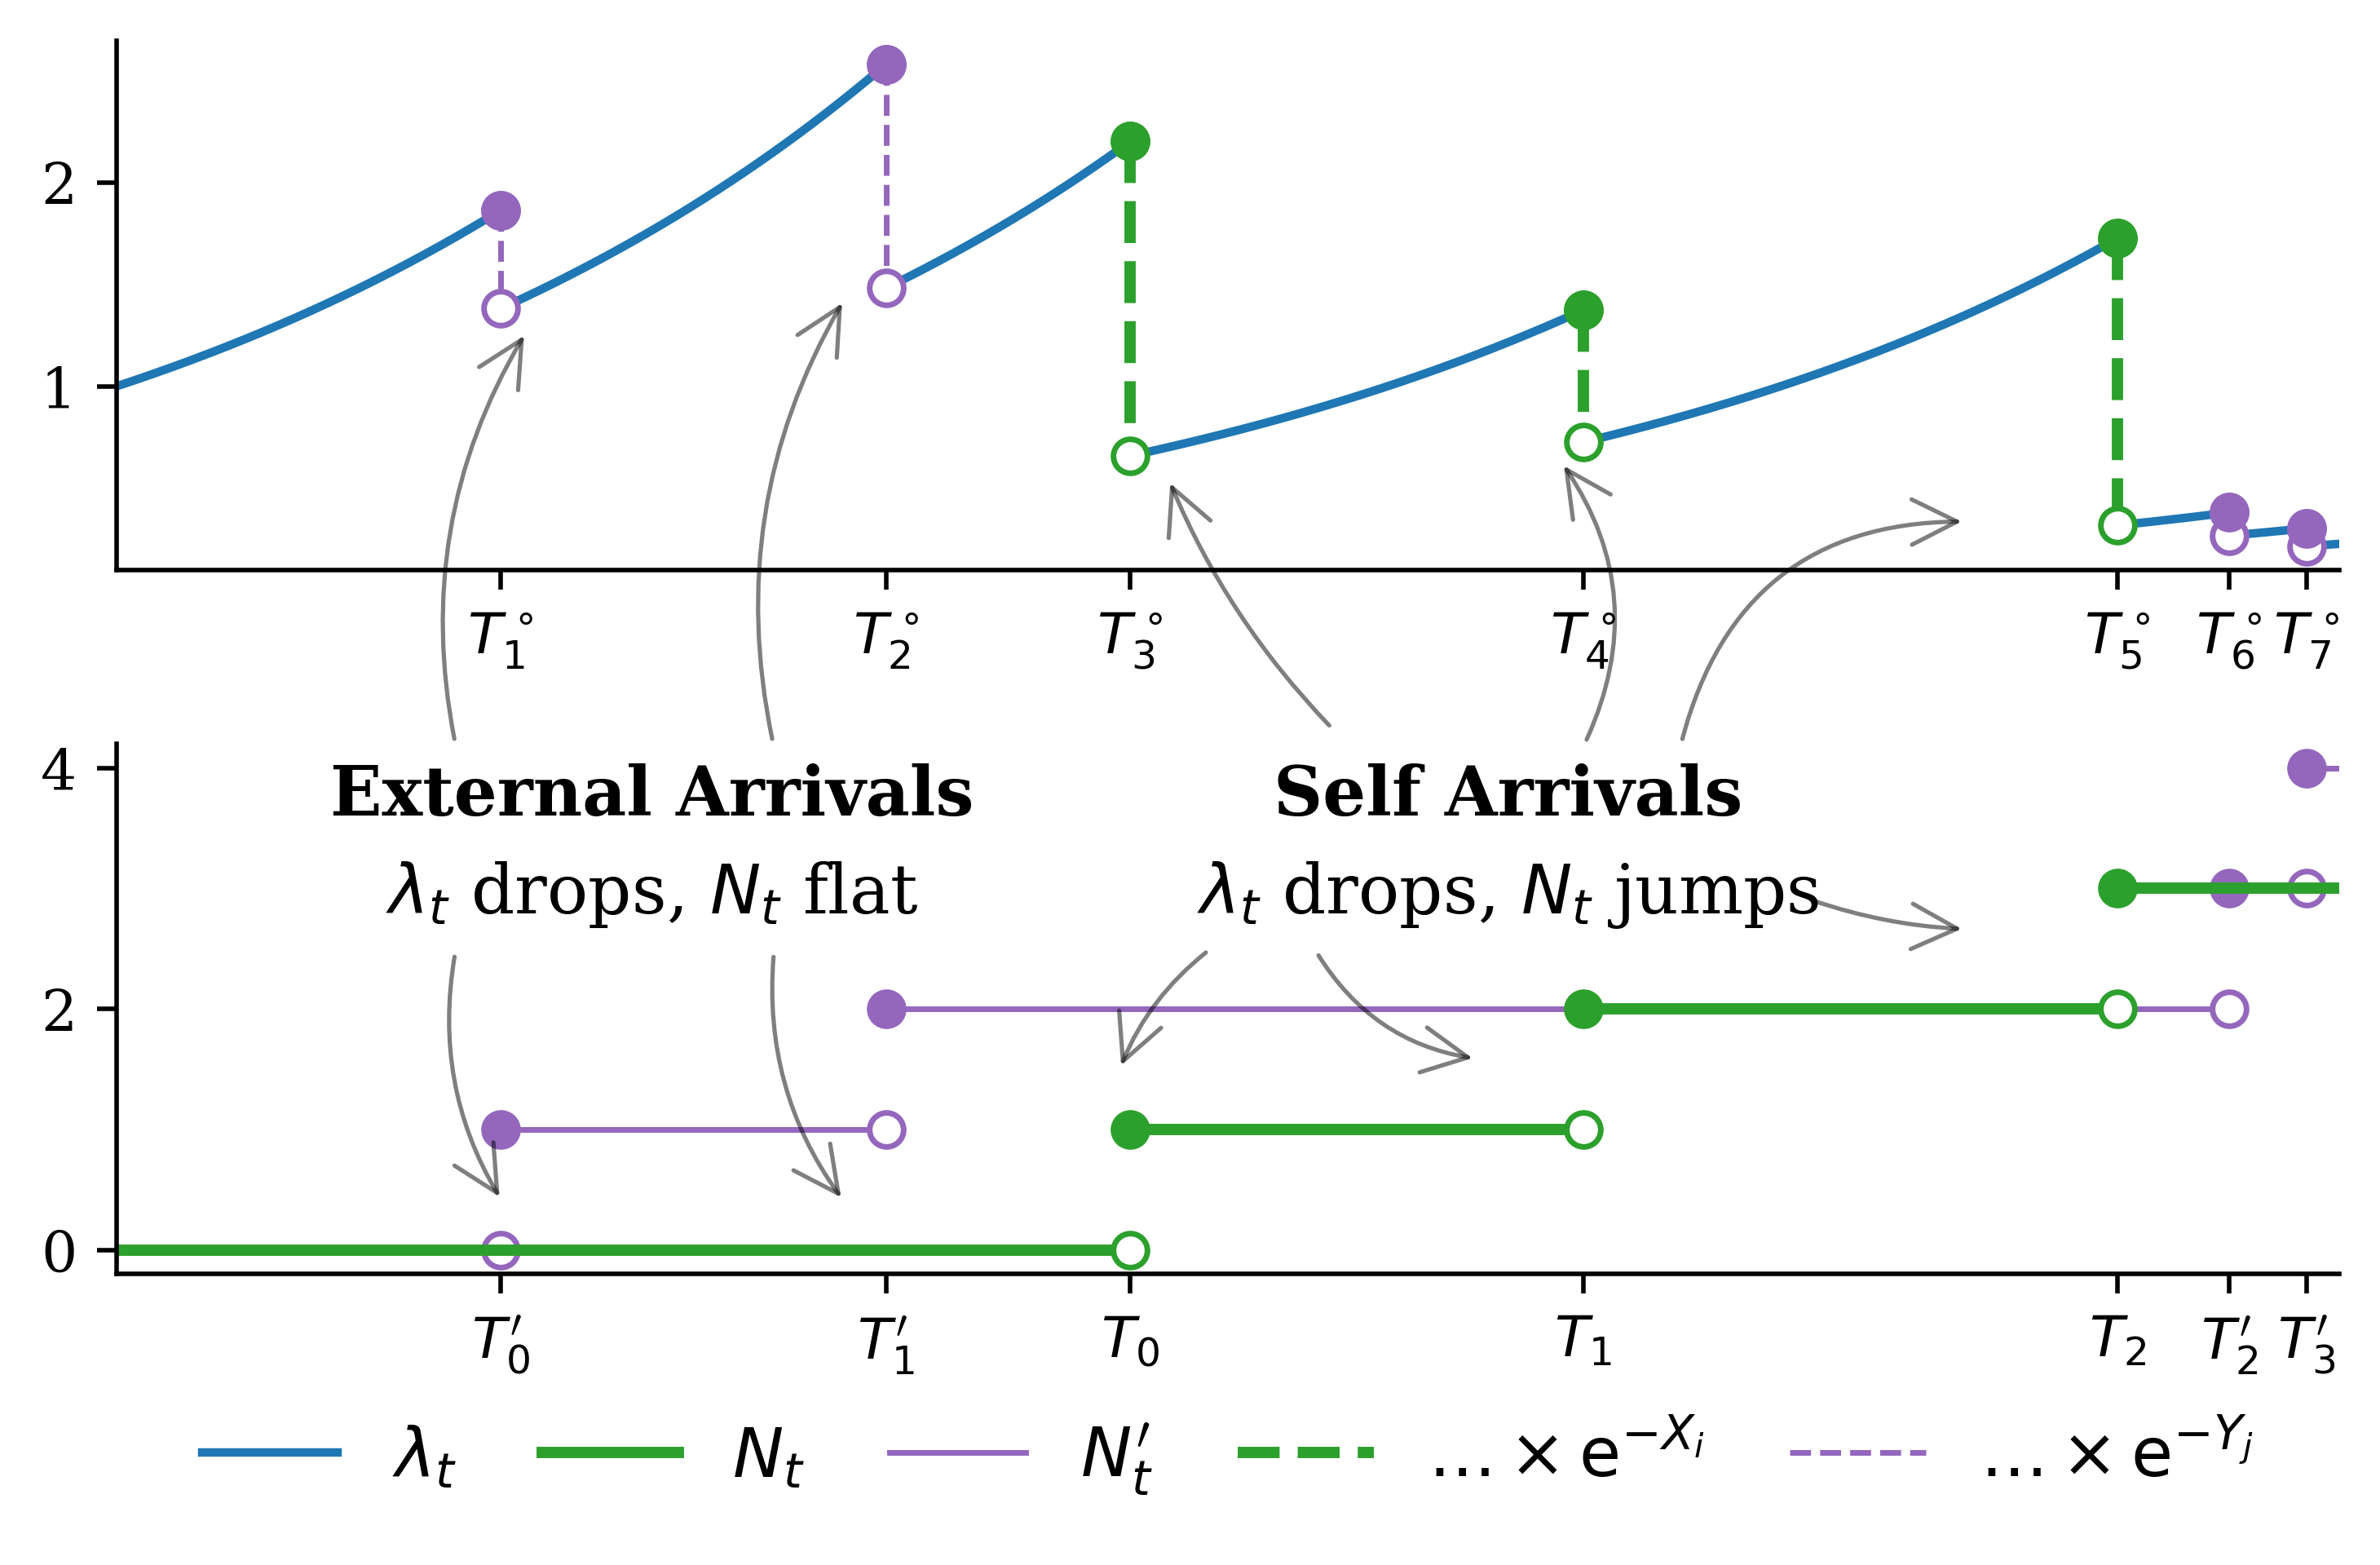

In [18]:
rnd.seed(2)
fig, axs = plt.subplots(2, 1, figsize=(6, 4), tight_layout=True)

ts, logLambdas, selfTs, extTs, Xs, Ys = simulate_exact_serially(
    lambda0, beta, lambdaS, lambdaE, rho, mat
)

tGrid = np.linspace(0, mat, 1000)

logInt = interp1d(ts, logLambdas, assume_sorted=True)
lambdas = np.exp(logInt(tGrid))
lambdas[:-1][np.diff(lambdas) < 0] = np.NaN

axs[0].plot(tGrid, lambdas, label="$\\lambda_t$")

axs[0].plot(selfTs, np.exp(logInt(selfTs - dt)), "o", c=selfCol)
axs[0].plot(extTs, np.exp(logInt(extTs - dt)), "o", c=extCol)

axs[0].scatter(selfTs, np.exp(logInt(selfTs - dt)), c=selfCol, zorder=4)
axs[0].scatter(extTs, np.exp(logInt(extTs - dt)), c=extCol, zorder=4)

axs[0].scatter(
    selfTs,
    np.exp(logInt(selfTs + dt)),
    edgecolors=selfCol,
    facecolors="white",
    zorder=3,
)
axs[0].scatter(
    extTs, np.exp(logInt(extTs + dt)), edgecolors=extCol, facecolors="white", zorder=3
)


vertTimesSelf = np.sort(np.concatenate([selfTs, selfTs - dt, selfTs + dt]))
vertLambdasSelf = np.exp(logInt(vertTimesSelf))
vertLambdasSelf[2::3] = np.NaN
axs[0].plot(
    vertTimesSelf,
    vertLambdasSelf,
    lw=2,
    ls="--",
    c=selfCol,
    label="$\\dots \\times \\mathrm{e}^{-X_i}$",
)

vertTimesExt = np.sort(np.concatenate([extTs, extTs - dt, extTs + dt]))
vertLambdasExt = np.exp(logInt(vertTimesExt))
vertLambdasExt[2::3] = np.NaN
axs[0].plot(
    vertTimesExt,
    vertLambdasExt,
    lw=1,
    ls="--",
    c=extCol,
    label="$\\dots \\times \\mathrm{e}^{-Y_j}$",
)

# plt.legend(frameon=False)
# xl = axs[0].get_xlim()
# axs[1].set_xlim(xl)

xl = [0, 2.4]
axs[0].set_xlim(xl)
axs[1].set_xlim(xl)
sns.despine()

create_steps(selfTs, xl[1], c=selfCol, zorder=2, label="$N_t$", lw=2)
create_steps(extTs, xl[1], c=extCol, label="$N_t'$", lw=1)

lines = sum([ax.get_legend_handles_labels()[0] for ax in axs], [])
labels = sum([ax.get_legend_handles_labels()[1] for ax in axs], [])

order = [0, 3, 4, 1, 2]
plt.legend(
    [lines[i] for i in order],
    [labels[i] for i in order],
    ncol=len(lines),
    frameon=False,
    bbox_to_anchor=(0.5, -0.35),
    loc="center",
    borderaxespad=0.0,
    labelspacing=0.2,
)

# plt.savefig("example.pgf")

targs = {"transform": fig.transFigure, "ha": "center"} #, "fontsize": 12}
faargs = {
    #     "color": "grey",
    "arrowstyle": "->",
    "transform": fig.transFigure,
    "mutation_scale": 20.0,
    "alpha": 0.5,
    "lw": 0.75,
    #     "ls": "--",
}

fig.text(0.28, 0.48, "External Arrivals", fontweight="bold", **targs)
fig.text(0.28, 0.42, "$\\lambda_t$ drops, $N_t$ flat", **targs)

fig.text(0.63, 0.48, "Self Arrivals", fontweight="bold", **targs)
fig.text(0.63, 0.42, "$\\lambda_t$ drops, $N_t$ jumps", **targs)

# Up arrows from left side
fig.patches.append(
    FancyArrowPatch(
        (0.2, 0.52), (0.23, 0.78), connectionstyle="arc3,rad=-0.2", **faargs
    )
)
fig.patches.append(
    FancyArrowPatch(
        (0.33, 0.52), (0.36, 0.8), connectionstyle="arc3,rad=-0.2", **faargs
    )
)

# Down arrows from left side
fig.patches.append(
    FancyArrowPatch((0.2, 0.4), (0.22, 0.24), connectionstyle="arc3,rad=0.2", **faargs)
)
fig.patches.append(
    FancyArrowPatch((0.33, 0.4), (0.36, 0.24), connectionstyle="arc3,rad=0.2", **faargs)
)

# Up arrows from right side
fig.patches.append(
    FancyArrowPatch(
        (0.56, 0.53), (0.49, 0.69), connectionstyle="arc3,rad=-0.1", **faargs
    )
)
fig.patches.append(
    FancyArrowPatch(
        (0.66, 0.52), (0.65, 0.7), connectionstyle="arc3,rad=0.3", **faargs
    )
)
fig.patches.append(
    FancyArrowPatch(
        (0.7, 0.52), (0.82, 0.66), connectionstyle="arc3,rad=-0.4", **faargs
    )
)

# Down arrows from right side
fig.patches.append(
    FancyArrowPatch((0.51, 0.4), (0.47, 0.32), connectionstyle="arc3,rad=0.15", **faargs)
)
fig.patches.append(
    FancyArrowPatch(
        (0.55, 0.4), (0.62, 0.33), connectionstyle="arc3,rad=0.25", **faargs
    )
)
fig.patches.append(
    FancyArrowPatch((0.75, 0.43), (0.82, 0.41), connectionstyle="arc3,rad=0.08", **faargs)
)

# fig.text(0.95, 0.7, "$t$", **targs)
# fig.text(0.95, 0.25, "$t$", **targs)

allTs = np.concatenate([selfTs, extTs])
axs[0].set_xticks(np.sort(allTs))
# axs[1].set_xticks(np.sort(selfTs))
axs[1].set_xticks(allTs)

axs[0].set_xticklabels([f"$T_{i}^\circ$" for i in range(1, len(allTs)+1)])
axs[1].set_xticklabels([f"$T_{i}$" for i in range(len(selfTs))] + [f"$T_{j}'$" for j in range(len(extTs))])
# axs[1].set_xticklabels([f"$T_{i}$" for i in range(1, len(selfTs)+1)])

axs[0].tick_params(axis='both', which='major', labelsize=10)
axs[1].tick_params(axis='both', which='major', labelsize=10)

axs[0].tick_params(axis='both', which='major', labelsize=10)
axs[1].tick_params(axis='both', which='major', labelsize=10)

plt.savefig("example-annotated2.pgf")
plt.show()

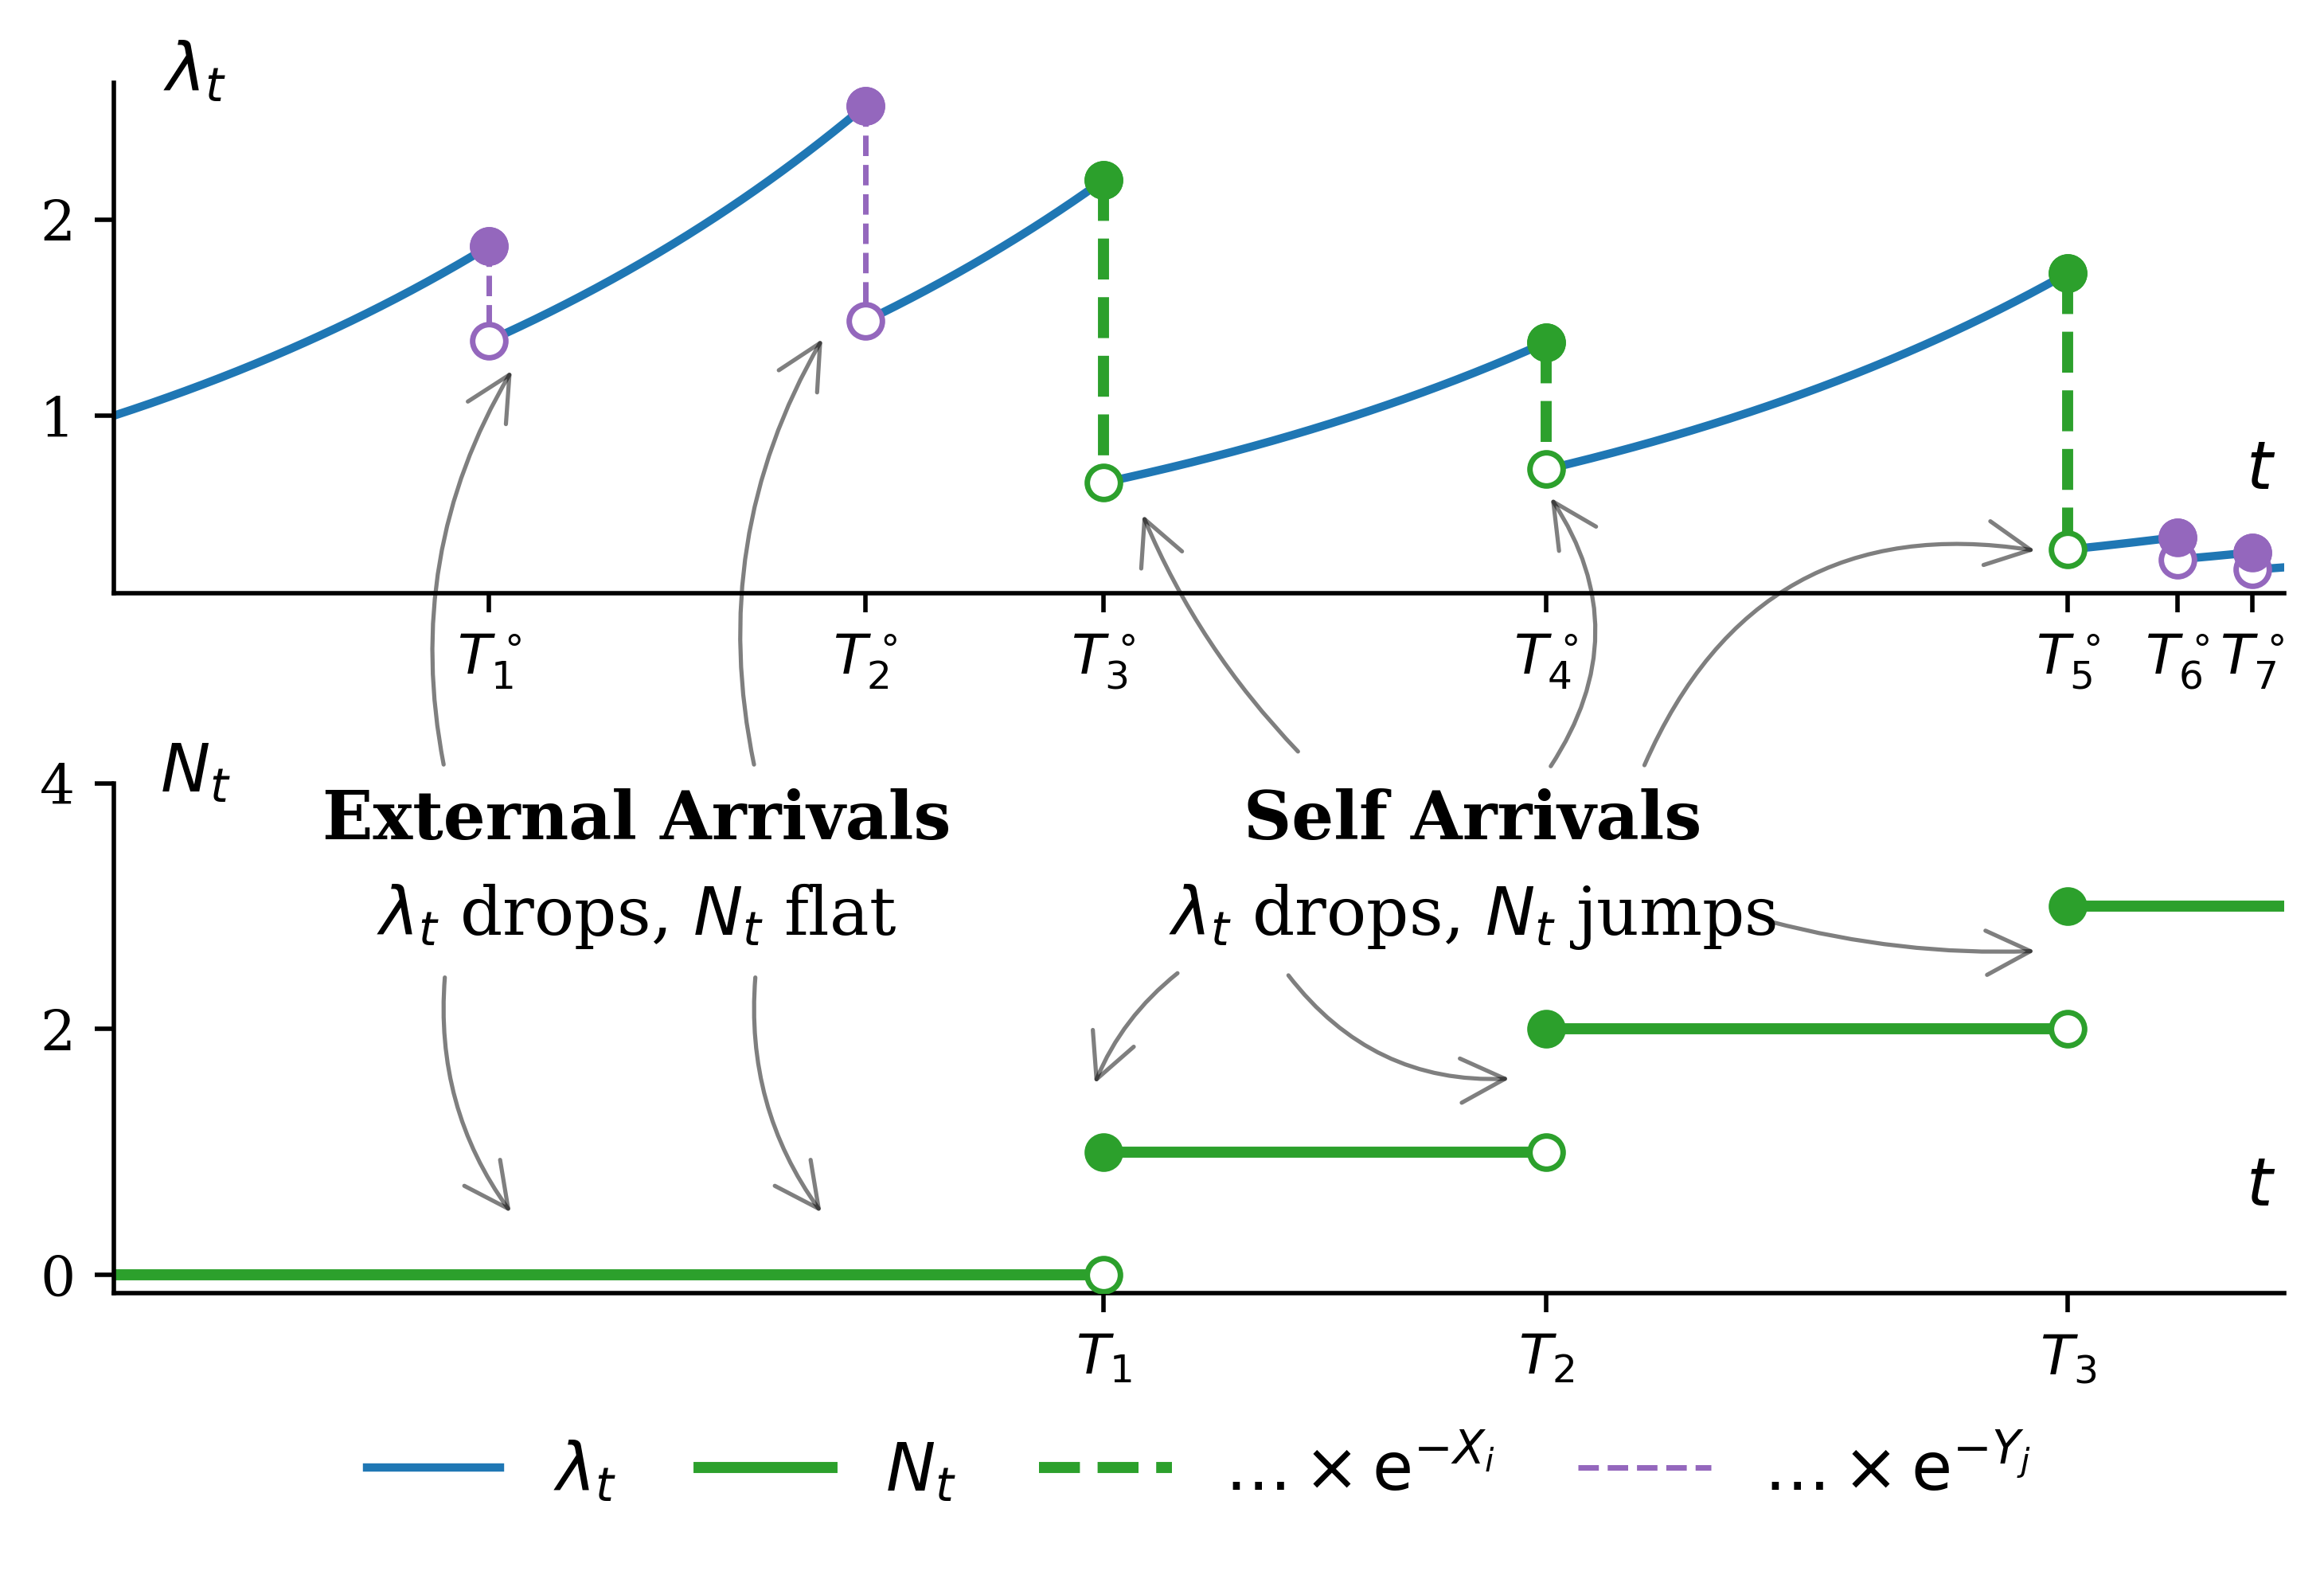

In [20]:
rnd.seed(2)
fig, axs = plt.subplots(2, 1, figsize=(6, 4), tight_layout=True)

ts, logLambdas, selfTs, extTs, Xs, Ys = simulate_exact_serially(
    lambda0, beta, lambdaS, lambdaE, rho, mat
)

tGrid = np.linspace(0, 2.4, 1000)

logInt = interp1d(ts, logLambdas, assume_sorted=True)
lambdas = np.exp(logInt(tGrid))
lambdas[:-1][np.diff(lambdas) < 0] = np.NaN

axs[0].plot(tGrid, lambdas, label="$\\lambda_t$")

axs[0].plot(selfTs, np.exp(logInt(selfTs - dt)), "o", c=selfCol)
axs[0].plot(extTs, np.exp(logInt(extTs - dt)), "o", c=extCol)

axs[0].scatter(selfTs, np.exp(logInt(selfTs - dt)), c=selfCol, zorder=4)
axs[0].scatter(extTs, np.exp(logInt(extTs - dt)), c=extCol, zorder=4)

axs[0].scatter(
    selfTs,
    np.exp(logInt(selfTs + dt)),
    edgecolors=selfCol,
    facecolors="white",
    zorder=3,
)
axs[0].scatter(
    extTs, np.exp(logInt(extTs + dt)), edgecolors=extCol, facecolors="white", zorder=3
)


vertTimesSelf = np.sort(np.concatenate([selfTs, selfTs - dt, selfTs + dt]))
vertLambdasSelf = np.exp(logInt(vertTimesSelf))
vertLambdasSelf[2::3] = np.NaN
axs[0].plot(
    vertTimesSelf,
    vertLambdasSelf,
    lw=2,
    ls="--",
    c=selfCol,
    label="$\\dots \\times \\mathrm{e}^{-X_i}$",
)

vertTimesExt = np.sort(np.concatenate([extTs, extTs - dt, extTs + dt]))
vertLambdasExt = np.exp(logInt(vertTimesExt))
vertLambdasExt[2::3] = np.NaN
axs[0].plot(
    vertTimesExt,
    vertLambdasExt,
    lw=1,
    ls="--",
    c=extCol,
    label="$\\dots \\times \\mathrm{e}^{-Y_j}$",
)

# plt.legend(frameon=False)
# xl = axs[0].get_xlim()
# axs[1].set_xlim(xl)


xl = [0, 2.4]
axs[0].set_xlim(xl)
axs[1].set_xlim(xl)

sns.despine()

create_steps(selfTs, xl[1], c=selfCol, zorder=2, label="$N_t$", lw=2)

yl = axs[1].get_ylim()
axs[1].set_ylim([yl[0], 4])

lines = sum([ax.get_legend_handles_labels()[0] for ax in axs], [])
labels = sum([ax.get_legend_handles_labels()[1] for ax in axs], [])

order = [0, 3, 1, 2]
plt.legend(
    [lines[i] for i in order],
    [labels[i] for i in order],
    ncol=len(lines),
    frameon=False,
    bbox_to_anchor=(0.5, -0.35),
    loc="center",
    borderaxespad=0.0,
    labelspacing=0.2,
)

targs = {"transform": fig.transFigure, "ha": "center"} #, "fontsize": 12}
faargs = {
    #     "color": "grey",
    "arrowstyle": "->",
    "transform": fig.transFigure,
    "mutation_scale": 20.0,
    "alpha": 0.5,
    "lw": 0.75,
    #     "ls": "--",
}

fig.text(0.28, 0.48, "External Arrivals", fontweight="bold", **targs)
fig.text(0.28, 0.42, "$\\lambda_t$ drops, $N_t$ flat", **targs)

fig.text(0.63, 0.48, "Self Arrivals", fontweight="bold", **targs)
fig.text(0.63, 0.42, "$\\lambda_t$ drops, $N_t$ jumps", **targs)


    
# Up arrows from left side
fig.patches.append(
    FancyArrowPatch(
        (0.2, 0.52), (0.23, 0.78), connectionstyle="arc3,rad=-0.2", **faargs
    )
)
fig.patches.append(
    FancyArrowPatch(
        (0.33, 0.52), (0.36, 0.8), connectionstyle="arc3,rad=-0.2", **faargs
    )
)

# Down arrows from left side
fig.patches.append(
    FancyArrowPatch((0.2, 0.4), (0.23, 0.24), connectionstyle="arc3,rad=0.2", **faargs)
)
fig.patches.append(
    FancyArrowPatch((0.33, 0.4), (0.36, 0.24), connectionstyle="arc3,rad=0.2", **faargs)
)

# Up arrows from right side
fig.patches.append(
    FancyArrowPatch(
        (0.56, 0.53), (0.49, 0.69), connectionstyle="arc3,rad=-0.1", **faargs
    )
)
fig.patches.append(
    FancyArrowPatch(
        (0.66, 0.52), (0.66, 0.7), connectionstyle="arc3,rad=0.35", **faargs
    )
)
fig.patches.append(
    FancyArrowPatch(
        (0.7, 0.52), (0.87, 0.66), connectionstyle="arc3,rad=-0.4", **faargs
    )
)

# Down arrows from right side
fig.patches.append(
    FancyArrowPatch((0.51, 0.4), (0.47, 0.32), connectionstyle="arc3,rad=0.15", **faargs)
)
fig.patches.append(
    FancyArrowPatch(
        (0.55, 0.4), (0.65, 0.33), connectionstyle="arc3,rad=0.28", **faargs
    )
)
fig.patches.append(
    FancyArrowPatch((0.75, 0.43), (0.87, 0.41), connectionstyle="arc3,rad=0.08", **faargs)
)

fig.text(0.095, 0.95, "$\\lambda_t$", **targs)
fig.text(0.095, 0.51, "$N_t$", **targs)
fig.text(0.96, 0.7, "$t$", **targs)
fig.text(0.96, 0.25, "$t$", **targs)

# yl = axs[0].get_ylim()
# axs[0].plot(selfTs, [0 for _ in selfTs], "^", c="k", markersize=7)
# print(axs[0].get_ylim())

# axs[0].set_ylim((0, yl[1]))
# print(axs[0].get_ylim())

allTs = np.concatenate([selfTs, extTs])
axs[0].set_xticks(np.sort(allTs))
axs[1].set_xticks(np.sort(selfTs))
# axs[0].set_xticklabels([f"$T_{i}$" for i in range(len(selfTs))] + [f"$T_{j}'$" for j in range(len(extTs))])
axs[0].set_xticklabels([f"$T_{i}^\circ$" for i in range(1, len(allTs)+1)])
axs[1].set_xticklabels([f"$T_{i}$" for i in range(1, len(selfTs)+1)])

axs[0].tick_params(axis='both', which='major', labelsize=10)
axs[1].tick_params(axis='both', which='major', labelsize=10)

plt.savefig("example-annotated2-no-external.pgf")
plt.show()